In [169]:
import pandas as pd
from datetime import datetime

In [170]:
# read in user_engagement data
user_engage = pd.read_csv('./takehome_user_engagement.csv', parse_dates=True)

In [171]:
# change time_stamp column to datetime object
user_engage['time_stamp'] = pd.to_datetime(user_engage['time_stamp'])

In [172]:
#print(user_engage.info())

In [173]:
# make sure data table is sorted by user_id, then time_stamp
user_engage = user_engage.sort_values(by=['user_id', 'time_stamp'])
#print(user_engage.head())

In [174]:
# calculate time difference between 3rd visit and 1st visit for each user
user_engage['time_between'] = user_engage.groupby('user_id')['time_stamp'].transform(lambda x: x - x.shift(2))
#user_engage.head()

In [177]:
# label adopted visit as 1, others as 0
user_engage['label'] = (user_engage['time_between'] < pd.Timedelta('7 days')).astype(int)
#print(user_engage.head(20))
#user_engage.info()

In [178]:
# label adopted users
adopted = user_engage.groupby('user_id')['label'].max()

In [179]:
# read in users file. Had to try different encoding as default utf-8 gave errors
user = pd.read_csv('./takehome_users.csv', encoding = "ISO-8859-1", parse_dates=True)
user['creation_time'] = pd.to_datetime(user['creation_time'])
#print(user.head())
#print(user.info())


In [180]:
# convert adopted Series to DataFrame and remove index to prepare for joining with users data
df_label = adopted.to_frame()
df_label = df_label.reset_index()
#print(df_label.info())

In [106]:
# merge users and user_engage data tables. Keep extra rows from users table
df_merge = user.merge(df_label, how='left', left_on='object_id', right_on='user_id')

In [181]:
# treat non-matched rows from users table as non-adopted users as they did not have any visit record
df_merge['label'].fillna(0, inplace=True)
df_merge['label'] = df_merge['label'].astype(int)
print(df_merge.info())
#print(df_merge.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
user_id                       8823 non-null float64
label                         12000 non-null int32
dtypes: datetime64[ns](1), float64(3), int32(1), int64(4), object(3)
memory usage: 1.1+ MB
None


## Now let's look at data

In [182]:
# calculated fraction of adopted users. It is pretty unbalanced data
df_merge.label.sum() / df_merge.label.count()

0.1335

In [183]:
print(df_merge.columns)

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'user_id',
       'label'],
      dtype='object')


In [211]:
def crosstab_output(index_col, col = df_merge.label):
    """ To generate a crosstab table containing normalized fraction for Positive class, and total frequency """
    df_crosstab = pd.DataFrame()
    df_crosstab['normalized'] = pd.crosstab(index_col, col, normalize='index', margins=True).iloc[:, 1]
    df_crosstab['total_frequency'] = pd.crosstab(index_col, col, margins=True).iloc[:, 2]
    
    return df_crosstab

In [212]:
crosstab_output(df_merge.creation_source)
# creation_source appears to predict adopted users to some degree

,normalized,total_frequency
creation_source,,
GUEST_INVITE,0.166436,2163
ORG_INVITE,0.129995,4254
PERSONAL_PROJECTS,0.077688,2111
SIGNUP,0.140393,2087
SIGNUP_GOOGLE_AUTH,0.167509,1385
All,0.133500,12000


In [213]:
crosstab_output(df_merge.opted_in_to_mailing_list)
# opted_in_to_mailing_list does not seem to predict adopted users

,normalized,total_frequency
opted_in_to_mailing_list,,
0,0.131912,9006
1,0.138277,2994
All,0.133500,12000


In [214]:
crosstab_output(df_merge.enabled_for_marketing_drip)
# enabled_for_marketing_drip does not seem to predict adopted users

,normalized,total_frequency
enabled_for_marketing_drip,,
0,0.132837,10208
1,0.137277,1792
All,0.133500,12000


In [216]:
crosstab_output(df_merge.org_id).sort_values(by='normalized', ascending=False)
# org_id has many levels, with small total frequency on each level
# hope to have better understanding on org_id and see if they can be combined into smaller number of org_ids

,normalized,total_frequency
org_id,,
387,0.583333,12
235,0.461538,13
270,0.428571,14
399,0.384615,13
392,0.375000,16
415,0.375000,16
400,0.375000,8
117,0.363636,22
345,0.357143,14


In [217]:
crosstab_output(df_merge.invited_by_user_id).sort_values(by='normalized', ascending=False)
# invited_by_user_id has many levels, with small total frequency on each level
# does not appear to be a good predictor variable

,normalized,total_frequency
invited_by_user_id,,
1787.0,1.0,1
4077.0,1.0,1
4629.0,1.0,1
2188.0,1.0,1
7524.0,1.0,1
10388.0,1.0,1
876.0,1.0,1
5981.0,1.0,1
5972.0,1.0,2


## Now try some modeling

In [261]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.externals import joblib     # for saving the model for future use

In [269]:
print(df_merge.head())
print(df_merge.info())

   object_id       creation_time               name  \
0          1 2014-04-22 03:53:30     Clausen August   
1          2 2013-11-15 03:45:04      Poole Matthew   
2          3 2013-03-19 23:14:52  Bottrill Mitchell   
3          4 2013-05-21 08:09:28    Clausen Nicklas   
4          5 2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2    

In [227]:
y = df_merge.label
X = df_merge[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']]

In [228]:
# handle categorical variables
X = pd.get_dummies(X)

In [231]:
# split 20% for test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 19)

In [235]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("ROC_AUC: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [232]:
# create instances of random forest classifier
rf_clf = RandomForestClassifier()

In [243]:
# define parameter distribution for random forest
param_dist_rf = {"n_estimators": sp_randint(100, 501),
                 "max_depth": sp_randint(1, 20),
                 "max_features": sp_randint(1, 8),
                 "min_samples_split": sp_randint(2, 41)
                }

In [244]:
n_iter_search_rf = 300
random_search_rf = RandomizedSearchCV(rf_clf, param_distributions=param_dist_rf,
                                   n_iter=n_iter_search_rf, cv=5, iid=False, scoring='roc_auc', n_jobs=-1)

start = time()
random_search_rf.fit(X_train, y_train)
print("Decision Tree RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search_rf))
report(random_search_rf.cv_results_)

Decision Tree RandomizedSearchCV took 339.19 seconds for 300 candidates parameter settings.
Model with rank: 1
ROC_AUC: 0.566 (std: 0.023)
Parameters: {'max_depth': 1, 'max_features': 1, 'min_samples_split': 34, 'n_estimators': 160}

Model with rank: 2
ROC_AUC: 0.566 (std: 0.022)
Parameters: {'max_depth': 2, 'max_features': 6, 'min_samples_split': 27, 'n_estimators': 294}

Model with rank: 3
ROC_AUC: 0.566 (std: 0.022)
Parameters: {'max_depth': 1, 'max_features': 1, 'min_samples_split': 22, 'n_estimators': 296}



In [254]:
# calculate roc_auc on setaside test data using best Random Forest model
auc_rf = roc_auc_score(y_test, random_search_rf.best_estimator_.predict_proba(X_test)[:,1])
print('Random Forest ROC_AUC score on test data: ', auc_rf)

Random Forest ROC_AUC score on test data:  0.5743643525541385


In [256]:
fpr, tpr, thresholds = roc_curve_test = roc_curve(y_test, random_search_rf.best_estimator_.predict_proba(X_test)[:,1])
print(fpr)
print(tpr)
print(thresholds)

[0.         0.01384909 0.0148042  0.02578797 0.10792741 0.13037249
 0.13753582 0.16093601 0.28271251 0.30897803 0.31948424 0.34383954
 0.46752627 0.50477555 0.51719198 0.56160458 0.80515759 0.82234957
 0.82808023 0.8591213  1.        ]
[0.         0.01633987 0.01960784 0.03921569 0.14052288 0.16666667
 0.17320261 0.19934641 0.38562092 0.41176471 0.4248366  0.45424837
 0.55228758 0.59150327 0.60457516 0.66666667 0.90196078 0.91176471
 0.91503268 0.9379085  1.        ]
[1.14202187 0.14202187 0.14162446 0.14129144 0.14089402 0.14034033
 0.13994292 0.1396099  0.13921249 0.13780561 0.1374082  0.13707518
 0.13667776 0.13514162 0.13474421 0.13441119 0.13401378 0.12551916
 0.12512174 0.12478872 0.12439131]


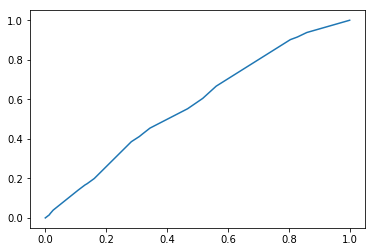

In [257]:
plt.plot(fpr, tpr)

In [263]:
confusion_matrix(y_test, random_search_rf.best_estimator_.predict(X_test))

array([[2094,    0],
       [ 306,    0]], dtype=int64)

In [268]:
from collections import Counter
Counter(random_search_rf.best_estimator_.predict(X_test))

Counter({0: 2400})

Text(0.5, 1.0, 'Random Forest Feature Importance Plot')

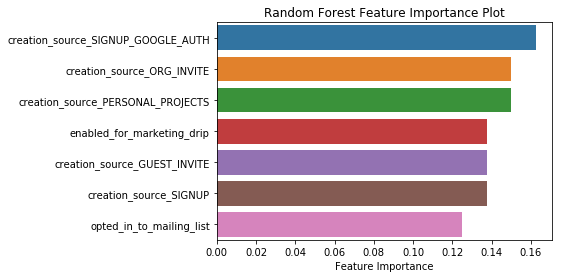

In [259]:
# for Random Forest, plot most important features
import seaborn as sns

rf_feature_importance = dict(zip(X.columns, random_search_rf.best_estimator_.feature_importances_))
rf_sorted_feature_importance = sorted(rf_feature_importance.items(), key=lambda kv: kv[1], reverse=True)
x_plot_rf = list(zip(*rf_sorted_feature_importance))[0]
y_plot_rf = list(zip(*rf_sorted_feature_importance))[1]
sns.barplot(y=list(x_plot_rf), x=list(y_plot_rf), orient='h')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance Plot')

In [241]:
X.shape

(12000, 7)